In [2]:
!pip uninstall numpy
!pip install numpy==1.23.5

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 wh

In [23]:
import numpy as np
print(np.__version__)


1.23.5


In [24]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2427 sha256=d9befefc8052db5a0d424171fea82f2918c0923965f371f7646d52b33967210c
  Stored in directory: /root/.cache/pip/wheels/6b/cc/b3/535ab5f86aef7106a855e71994084f82a435097ef92a3f7e5a
Successfully built colabgymrender


In [25]:
from colabgymrender.recorder import Recorder

In [26]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [27]:
env = gym.make('MountainCar-v0')
#env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [28]:
total_reward

-200.0

In [29]:
'''
# Hyperparameters cho toy game CartPole
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency
'''

# Hyperpparameters cho toy game MountainCar
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 100000
epsilon_decay_intervals = 2000
gamma = 0.95
alpha = 1e-4

memory_size = 200000
min_replay_size = 1000
batch_size = 128

target_update_frequency = 500


Giải thích các thay đổi từ bài toán CartPole sang bài toán MountainCar
+ max_num_steps: Tăng từ 50,000 lên 100,000
+ epsilon_decay_intervals: Giảm từ 10,000 xuống 2,000 để giảm epsilon nhanh hơn
+ gamma: Giảm từ 0.99 xuống 0.95 để tập trung vào phần thưởng ngắn hạn
+ alpha: Giảm từ 5e-4 xuống 1e-4 để tăng độ ổn định khi học
+ memory_size: Tăng từ 50,000 lên 200,000 để lưu trữ nhiều trải nghiệm hơn
+ batch_size: Tăng từ 32 lên 128
+ target_update_frequency: Giảm từ 1,000 xuống 500 để cập nhật mạng đích thường xuyên hơn

Thay đổi trong mạng Neural:
+ input layer: Tăng từ env.observation_space.shape[0] -> 64 lên env.observation_space.shape[0] -> 128.
+ Thêm layer nn.Linear(128, 128)
+ Thêm layer nn.Linear(128, 64)

In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            #Kiến trúc mạng ban đầu
            #nn.Linear(env.observation_space.shape[0], 64),
            #nn.Tanh(),
            #nn.Linear(64, env.action_space.n)

            nn.Linear(env.observation_space.shape[0], 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [31]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [32]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [33]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -198.6
Episode: 15 Step: 3000 Average reward: -199.06666666666666
Episode: 20 Step: 4000 Average reward: -199.3
Episode: 25 Step: 5000 Average reward: -199.44
Episode: 30 Step: 6000 Average reward: -199.53333333333333
Episode: 35 Step: 7000 Average reward: -199.6
Episode: 40 Step: 8000 Average reward: -199.65
Episode: 45 Step: 9000 Average reward: -199.6888888888889
Episode: 50 Step: 10000 Average reward: -199.72
Episode: 55 Step: 11000 Average reward: -199.74545454545455
Episode: 60 Step: 12000 Average reward: -199.76666666666668
Episode: 65 Step: 13000 Average reward: -199.7846153846154
Episode: 70 Step: 14000 Average reward: -199.8
Episode: 75 Step: 15000 Average reward: -199.81333333333333
Episode: 80 Step: 16000 Average reward: -199.825
Episode: 85 Step: 17000 Average reward: -199.83529411764707
Episode: 90 Step: 18000 Average reward: -199.84444444444443
Episode: 95 Step: 19000 Average reward: -199

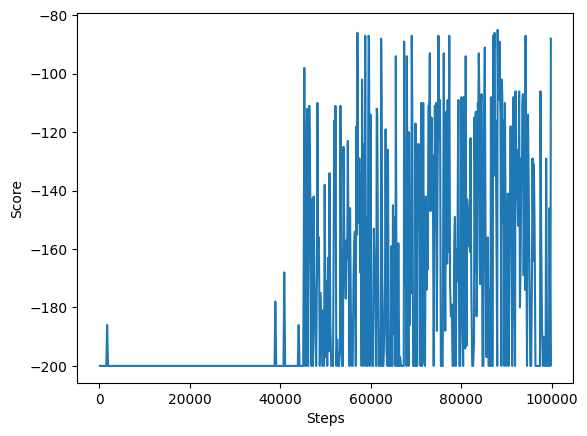

In [36]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [37]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-139.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  89%|████████▊ | 125/141 [00:00<00:00, 424.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1749121158.237245.mp4, 720000 bytes wanted but 0 bytes read,at frame 140/141, at time 4.67/4.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4
